<a href="https://colab.research.google.com/github/AbouCamara/COURS-IA/blob/main/Classlocat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [245]:
# This will import the python's module os
import os
from scipy import io
import cv2
import matplotlib.pyplot as plt
import pandas as pd
# imgaug: load and save images
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np
import imageio

from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import re

from sklearn.preprocessing import LabelEncoder

from keras.utils import to_categorical

import random

from sklearn.model_selection import train_test_split

from keras.models import load_model
from keras.layers import Lambda
import tensorflow as tf

import sys 
from six.moves import input as raw_input
from keras.layers import Input

from keras.layers import Activation, Dense
from tensorflow.keras.layers import Dense

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
import keras.backend as K
import math

def extract_mat_contents(annot_directory, image_dir):
	        # Create MAT Parser
	        mat = scipy.io.loadmat(annot_directory)
	        # Get the height and width for our image
	        height, width = cv2.imread(image_dir).shape[:2]
	        # Get the bounding box co-ordinates
	        x1, y2, y1, x2 = tuple(map(tuple, mat['box_coord']))[0]
	        # We Split the image Directory passed in the method and choose the index
	        # Of the Folders name which is the same as it's class
	        class_name = image_dir.split('/')[2]
	        filename = '/'.join(image_dir.split('/')[-2:])
	        # Return the extracted attributes
	        return filename,  width, height, class_name, x1,y1,x2,y2

In [246]:
# Function to convert MAT files to CSV
def mat_to_csv(annot_directory, image_directory, classes_folders):

  # List containing all our attributes regarding each image
  mat_list = []

  # We loop our each class and its labels one by one to preprocess and augment 
  for class_folder in classes_folders:

    # Set our images and annotations directory
    image_dir = os.path.join(image_directory, class_folder)
    annot_dir = os.path.join(annot_directory, class_folder) 

    # Get each file in the image and annotation directory
    mat_files = sorted(os.listdir(annot_dir))
    img_files = sorted(os.listdir(image_dir))

    # Loop over each of the image and its label
    for mat, image_file in zip(mat_files, img_files):
      
      # Full mat path
      mat_path = os.path.join(annot_dir, mat)

      # Full path Image
      img_path = os.path.join(image_dir, image_file)

      # Get Attributes for each image 
      value = extract_mat_contents(mat_path, img_path)

      # Append the attributes to the mat_list
      mat_list.append(value)

  # Columns for Pandas DataFrame
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 
                 'xmax', 'ymax']

  # Create the DataFrame from mat_list
  mat_df = pd.DataFrame(mat_list, columns=column_name)

  # Return the dataframe
  return mat_df

# The Classes we will use for our training
classes_list = sorted(['butterfly',  'cougar_face', 'elephant'])


# Set our images and annotations directory
image_directory = 'CALTECH/CALTECH_Dataset'
annot_directory = 'CALTECH/CALTECH_Annotations'

# Run the function to convert all the MAT files to a Pandas DataFrame
labels_df = mat_to_csv(annot_directory, image_directory, classes_list)

# Saving the Pandas DataFrame as CSV File
labels_df.to_csv(('labels.csv'), index=None)

In [247]:
# Function to convert bounding box image into DataFrame 
def bounding_boxes_to_df(bounding_boxes_object):

    # Convert Bounding Boxes Object to Array
    bounding_boxes_array = bounding_boxes_object.to_xyxy_array()
    
    # Convert the array into DataFrame
    df_bounding_boxes = pd.DataFrame(bounding_boxes_array, 
                                     columns=['xmin', 'ymin', 'xmax', 'ymax'])
    
    # Return the DataFrame
    return df_bounding_boxes

In [248]:
# Define all the Augmentations you want to apply to your dataset
# We're setting random `n` agumentations to 2. 
image_augmentations = iaa.SomeOf( 2,
    [                                 
    # Scale the Images
    iaa.Affine(scale=(0.5, 1.5)),

    # Rotate the Images
    iaa.Affine(rotate=(-60, 60)),

    # Shift the Image
    iaa.Affine(translate_percent={"x":(-0.3, 0.3),"y":(-0.3, 0.3)}),

    # Flip the Image
    iaa.Fliplr(1),

    # Increase or decrease the brightness
    iaa.Multiply((0.5, 1.5)),

    # Add Gaussian Blur
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
    
    # Add Gaussian Noise
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))

])


In [249]:
def image_aug(df, images_path, aug_images_path, augmentor, multiple = 3):
    
    # Fill this DataFrame with image attributes
    augmentations_df = pd.DataFrame(
        columns=['filename','width','height','class', 'xmin', 'ymin', 'xmax',
                 'ymax'])
    
    # Group the data by filenames
    grouped_df = df.groupby('filename')

    # Create the directory for all augmentated images
    if not os.path.exists(aug_images_path):
      os.mkdir(aug_images_path)

    # Create directories for each class of augmentated images
    for folder in df['class'].unique():
      if not os.path.exists(os.path.join(aug_images_path, folder)):
        os.mkdir(os.path.join(aug_images_path, folder))

    for i in range(multiple):
      
      # Post Fix we add to the each different augmentation of one image
      image_postfix = str(i)

      # Loop to perform the augmentations
      for filename in df['filename'].unique():

        augmented_path = os.path.join(aug_images_path, filename)+image_postfix+'.jpg'

        # Take one image at a time with its information
        single_image = grouped_df.get_group(filename)
        single_image = single_image.reset_index()
        single_image = single_image.drop(['index'], axis=1)   
        
        # Read the image
        image = imageio.imread(os.path.join(images_path, filename))

        # Get bounding box
        bounding_box_array = single_image.drop(['filename', 'width', 'height',
                                                'class'], axis=1).values

        # Give the bounding box to imgaug library
        bounding_box = BoundingBoxesOnImage.from_xyxy_array(bounding_box_array, 
                                                            shape=image.shape)

        # Perform random 2 Augmentations
        image_aug, bounding_box_aug = augmentor(image=image, 
                                                bounding_boxes=bounding_box)
        
        # Discard the the bounding box going out the image completely   
        bounding_box_aug = bounding_box_aug.remove_out_of_image()

        # Clip the bounding box that are only partially out of th image
        bounding_box_aug = bounding_box_aug.clip_out_of_image()

        # Get rid of the the image if bounding box was discarded  
        if re.findall('Image...', str(bounding_box_aug)) == ['Image([]']:
            pass
        
        else:
        
          # Create the augmented image file
          imageio.imwrite(augmented_path, image_aug) 

          # Update the image width and height after augmentation
          info_df = single_image.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
          for index, _ in info_df.iterrows():
              info_df.at[index, 'width'] = image_aug.shape[1]
              info_df.at[index, 'height'] = image_aug.shape[0]

          # Add the prefix to each image to differentiate if required
          info_df['filename'] = info_df['filename'].apply(lambda x: x + image_postfix + '.jpg')

          # Create the augmented bounding boxes dataframe 
          bounding_box_df = bounding_boxes_to_df(bounding_box_aug)

          # Concatenate the filenames, height, width and bounding boxes 
          aug_df = pd.concat([info_df, bounding_box_df], axis=1)

          # Add all the information to augmentations_df we initialized above
          augmentations_df = pd.concat([augmentations_df, aug_df])            
      
    # Remove index
    augmentations_df = augmentations_df.reset_index()
    augmentations_df = augmentations_df.drop(['index'], axis=1)

    # Return the Dataframe
    return augmentations_df


augmented_images_df = image_aug(labels_df, image_directory, 'aug_images', 
                                image_augmentations)

In [250]:
augmented_images_df = augmented_images_df.sort_values('filename', ignore_index= True)
augmented_images_df.to_csv('aug.csv')

# Check Dataset Size
print('Our total dataset Size before the augmentations was: ', len(labels_df))
print('Our total dataset Size after the augmentations is: ', len(augmented_images_df))


Our total dataset Size before the augmentations was:  216
Our total dataset Size after the augmentations is:  648


In [251]:
def preprocess_dataset(image_folder, classes_list, df, image_size = 300,):


  # Lists that will contain the whole dataset
  labels = []
  boxes = []
  img_list = []

  # Get height and width of each image in the datafame
  h = df['height']
  w = df['width']

  # Create a copy of the labels in the dataframe
  labels = list(df['class'])

  # Create a copy of the bounding box values and also normalize them 
  for x1, y1, x2, y2 in zip(list(df['xmin']/w), list(df['ymin']/h), 
                            list(df['xmax']/w), list(df['ymax']/h)):
    
    arr = [x1, y1, x2, y2]
    boxes.append(arr)

  # We loop over each class and its labels 
  for class_folder in classes_list:  

    # Set our images directory
    image_dir = os.path.join(image_folder, class_folder)

    # Annotation and Image files
    img_files = sorted(os.listdir(image_dir))

    # Loop over each of the image and its label
    for image_file in img_files:

      # Full path Image
      img_path = os.path.join(image_dir, image_file)

      # Read the image
      img  = cv2.imread(img_path)

      # Resize all images to a fix size
      image = cv2.resize(img, (image_size, image_size))

      # Convert the image from BGR to RGB as NasNetMobile was trained on RGB images
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Normalize the image by dividing it by 255.0 
      image = image.astype("float") / 255.0

      # Append it to the list of images
      img_list.append(image)

  return labels, boxes, img_list

In [252]:
# All images will resized to 300, 300 
image_size = 300

# Get Augmented images and bounding boxes
labels, boxes, img_list = preprocess_dataset('aug_images', classes_list,
                                             augmented_images_df)


In [253]:
# Convert labels to integers, then one hot encode them
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
onehot_labels = to_categorical(integer_labels)

# Now we need to shuffle the data, so zip all lists and shuffle
combined_list = list(zip(img_list, boxes, onehot_labels))
random.shuffle(combined_list)

# Extract back the contents of each list
img_list, boxes, onehot_labels = zip(*combined_list)

print('All Done')


All Done


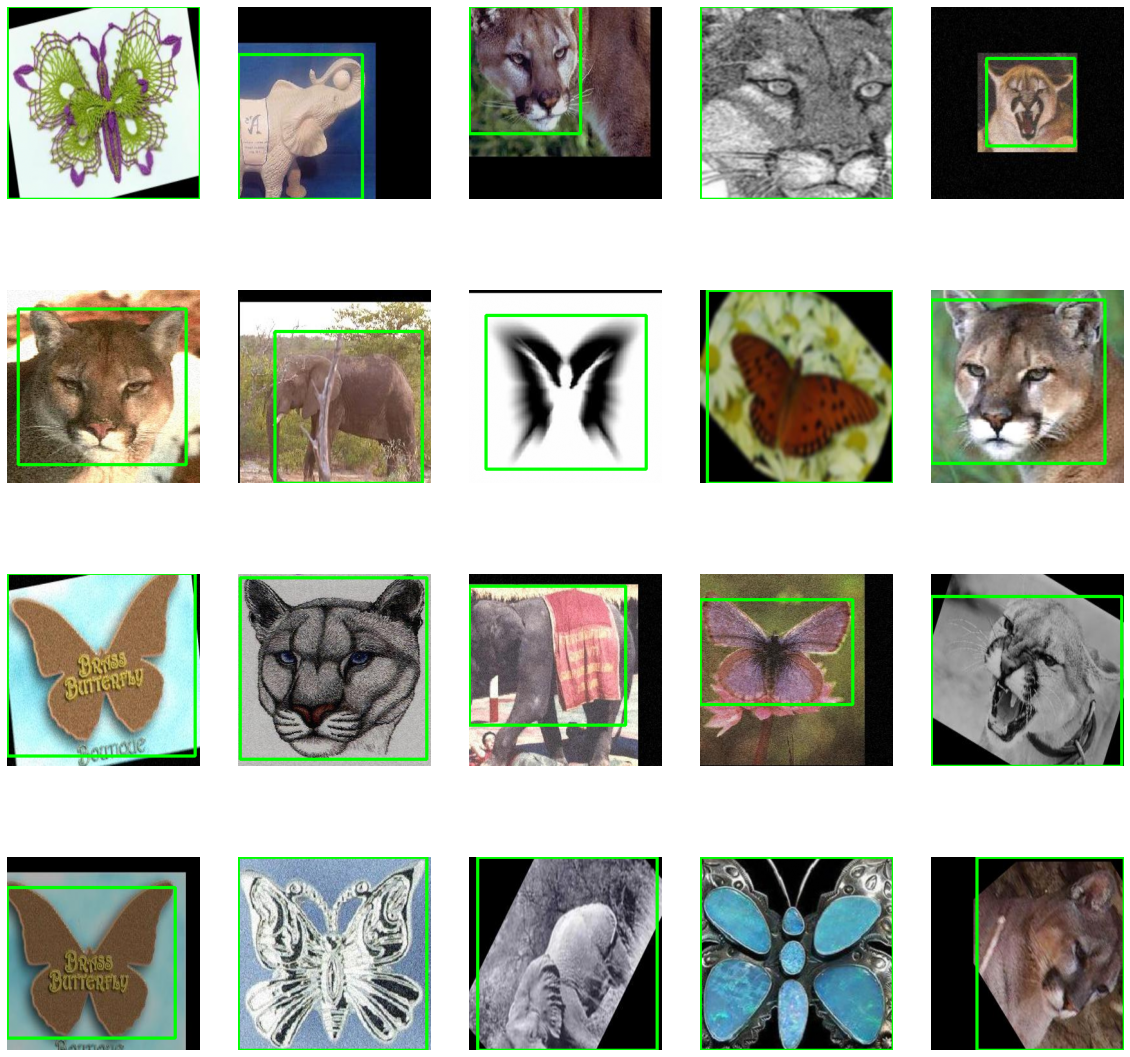

In [254]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20));

# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, len(img_list)), 20)

for iteration, i in enumerate(random_range, 1):

    # Bounding box of each image
    a1, b1, a2, b2 = boxes[i];

    # Rescaling the boundig box values to match the image size
    x1 = a1 * image_size
    x2 = a2 * image_size
    y1 = b1 * image_size
    y2 = b2 * image_size

    # The image to visualize
    image = img_list[i]

    # Draw bounding boxes on the image
    cv2.rectangle(image, (int(x1),int(y1)),
          (int(x2),int(y2)),
                  (0,255,0),
                  3);
    
    # Clip the values to 0-1 and draw the sample of images
    image = np.clip(img_list[i], 0, 1)
    plt.subplot(4, 5, iteration);
    plt.imshow(image);
    plt.axis('off');


In [255]:
# Split the data of images, labels and their annotations
train_images, val_images, train_labels, \
val_labels, train_boxes, val_boxes = train_test_split( np.array(img_list), 
                np.array(onehot_labels), np.array(boxes), test_size = 0.1, 
                random_state = 43)

print('Total Training Images: {}, Total Test Images: {}'.format(
    len(train_images), 
    len(val_images)
    ))

Total Training Images: 583, Total Test Images: 65


In [256]:
# Load the NasNetMobile Model, make sure to exclude the top for transfer learning
N_mobile = tf.keras.applications.NASNetMobile( input_tensor = Input(
    shape=(image_size, image_size, 3)), 
    include_top=False, 
    weights='imagenet'
    )

In [257]:
# Let's create a function that will construct our model
def create_model(no_of_classes):

    # Freeze the whole model
    N_mobile.trainable = False
    
    # Start by taking the output feature maps from NASNETMobile
    base_model_output = N_mobile.output
    
    # Convert to a single-dimensional vector by Global Average Pooling.

    # We could also use Flatten()(x) but GAP is more effective, it reduces 
    # Parameters and controls overfitting.
    flattened_output = GlobalAveragePooling2D()(base_model_output)

    # Create our Classification Head, final layer contains 
    # Ouput units = no. classes
    class_prediction = Dense(256, activation="relu")(flattened_output)
    class_prediction = Dense(128, activation="relu")(class_prediction )
    class_prediction = Dropout(0.2)(class_prediction)
    class_prediction = Dense(64, activation="relu")(class_prediction)
    class_prediction = Dropout(0.2)(class_prediction )
    class_prediction = Dense(32, activation="relu")(class_prediction)
    class_prediction = Dense(no_of_classes, activation='softmax',
                             name="class_output")(class_prediction)

    # Create Our Localization Head, final layer contains 4 nodes for x1,y1,x2,y2
    # Respectively.
    box_output = Dense(256, activation="relu")(flattened_output)
    box_output = Dense(128, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output )

    box_output = Dense(64, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output )

    box_output = Dense(32, activation="relu")(box_output)
    box_predictions = Dense(4, activation='sigmoid',
                            name= "box_output")(box_output)

    # Now combine the two heads
    model = Model(inputs=N_mobile.input, outputs= [box_predictions, 
                                                   class_prediction])

    return model

# Create the model for 3 classes, Elephant, Butterfly, Cougar-Face
model = create_model(3)
print("Model Created")


Model Created
